In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_FITNESS_ADVANTAGE": fitness_advantage,
        "MILL_REPLICATE": replicate,
    }
    for replicate in range(10)
    for fitness_advantage in [0.0, 1.0, 1.0]
]

for i, pp in enumerate(parameter_packs):
    with open(
        f"gene-selection-inference-parameterization-{i}.yaml", "w"
    ) as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_FITNESS_ADVANTAGE: float
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_FITNESS_ADVANTAGE = 1.0
MILL_REPLICATE = 9


In [5]:
import copy
import random

import alifedata_phyloinformatics_convert as apc
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools
from hstrat import hstrat
from keyname import keyname as kn
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


# Parameters


In [7]:
HSTRAT_RESOLUTION = 1000
HSTRAT_DIFFERENTIA_WIDTH = 64

TOURNAMENT_SIZE = 2

NGEN = 200

POPULATION_SIZE = 400


# Setup


In [8]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register(
    "individual",
    lambda *args, **kwargs: deap_creator.Individual([0.0]),
    deap_creator.Individual,
    n=1,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (individual[0] + random.random(),)


toolbox.register("evaluate", evalOneMax)
# hack to ensure gene annotation remains associated with gene
toolbox.register("mate", lambda x, y: random.choice([(x, y), (y, x)]))
toolbox.register("mutate", lambda x: tuple(x))
toolbox.register("select", deap_tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Decorate the variation operators
toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [9]:
# Create the population and populate the history
population = toolbox.population(n=POPULATION_SIZE)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.nominal_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = hstrat.HereditaryStratigraphicColumn(
        stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
        stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
        initial_stratum_annotation=0,
    ).CloneDescendant(0)


# Do the evolution, the decorators will take care of updating the
# history
prevalences = []
for gen in tqdm(range(NGEN)):
    prevalences.append(sum(1 for x in population if x[0] > 0))

    offspring = deap_algorithms.varAnd(
        population, toolbox, cxpb=1.0, mutpb=0.0
    )
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    population = [copy.deepcopy(ind) for ind in population]

    if gen >= NGEN // 4:
        if prevalences[-1] == 0:
            population[0][0] = MILL_FITNESS_ADVANTAGE



  0%|                                                                  | 0/200 [00:00<?, ?it/s]

  0%|▎                                                         | 1/200 [00:00<02:24,  1.38it/s]

  1%|▌                                                         | 2/200 [00:01<02:33,  1.29it/s]

  2%|▊                                                         | 3/200 [00:02<02:45,  1.19it/s]

  2%|█▏                                                        | 4/200 [00:03<03:06,  1.05it/s]

  2%|█▍                                                        | 5/200 [00:04<03:05,  1.05it/s]

  3%|█▋                                                        | 6/200 [00:05<03:35,  1.11s/it]

  4%|██                                                        | 7/200 [00:06<03:16,  1.02s/it]

  4%|██▎                                                       | 8/200 [00:07<03:07,  1.03it/s]

  4%|██▌                                                       | 9/200 [00:08<03:26,  1.08s/it]

  5%|██▊                                                      | 10/200 [00:10<03:25,  1.08s/it]

  6%|███▏                                                     | 11/200 [00:10<03:02,  1.04it/s]

  6%|███▍                                                     | 12/200 [00:11<03:06,  1.01it/s]

  6%|███▋                                                     | 13/200 [00:12<03:12,  1.03s/it]

  7%|███▉                                                     | 14/200 [00:14<03:24,  1.10s/it]

  8%|████▎                                                    | 15/200 [00:15<03:14,  1.05s/it]

  8%|████▌                                                    | 16/200 [00:15<02:47,  1.10it/s]

  8%|████▊                                                    | 17/200 [00:16<02:38,  1.16it/s]

  9%|█████▏                                                   | 18/200 [00:17<02:34,  1.18it/s]

 10%|█████▍                                                   | 19/200 [00:18<02:31,  1.20it/s]

 10%|█████▋                                                   | 20/200 [00:18<02:19,  1.29it/s]

 10%|█████▉                                                   | 21/200 [00:19<02:23,  1.25it/s]

 11%|██████▎                                                  | 22/200 [00:20<02:26,  1.21it/s]

 12%|██████▌                                                  | 23/200 [00:21<02:32,  1.16it/s]

 12%|██████▊                                                  | 24/200 [00:22<02:36,  1.12it/s]

 12%|███████▏                                                 | 25/200 [00:23<02:34,  1.13it/s]

 13%|███████▍                                                 | 26/200 [00:23<02:25,  1.20it/s]

 14%|███████▋                                                 | 27/200 [00:24<02:27,  1.17it/s]

 14%|███████▉                                                 | 28/200 [00:25<02:30,  1.14it/s]

 14%|████████▎                                                | 29/200 [00:26<02:35,  1.10it/s]

 15%|████████▌                                                | 30/200 [00:27<02:38,  1.07it/s]

 16%|████████▊                                                | 31/200 [00:28<02:38,  1.07it/s]

 16%|█████████                                                | 32/200 [00:29<02:37,  1.07it/s]

 16%|█████████▍                                               | 33/200 [00:30<02:29,  1.12it/s]

 17%|█████████▋                                               | 34/200 [00:31<02:33,  1.08it/s]

 18%|█████████▉                                               | 35/200 [00:32<02:37,  1.05it/s]

 18%|██████████▎                                              | 36/200 [00:33<02:40,  1.02it/s]

 18%|██████████▌                                              | 37/200 [00:34<02:43,  1.00s/it]

 19%|██████████▊                                              | 38/200 [00:35<02:43,  1.01s/it]

 20%|███████████                                              | 39/200 [00:36<02:43,  1.02s/it]

 20%|███████████▍                                             | 40/200 [00:37<02:44,  1.03s/it]

 20%|███████████▋                                             | 41/200 [00:38<02:44,  1.04s/it]

 21%|███████████▉                                             | 42/200 [00:39<02:44,  1.04s/it]

 22%|████████████▎                                            | 43/200 [00:40<02:43,  1.04s/it]

 22%|████████████▌                                            | 44/200 [00:41<02:44,  1.05s/it]

 22%|████████████▊                                            | 45/200 [00:43<02:47,  1.08s/it]

 23%|█████████████                                            | 46/200 [00:44<02:48,  1.09s/it]

 24%|█████████████▍                                           | 47/200 [00:45<02:48,  1.10s/it]

 24%|█████████████▋                                           | 48/200 [00:46<02:46,  1.10s/it]

 24%|█████████████▉                                           | 49/200 [00:47<02:47,  1.11s/it]

 25%|██████████████▎                                          | 50/200 [00:48<02:50,  1.14s/it]

 26%|██████████████▌                                          | 51/200 [00:49<02:49,  1.14s/it]

 26%|██████████████▊                                          | 52/200 [00:51<02:50,  1.15s/it]

 26%|███████████████                                          | 53/200 [00:52<02:50,  1.16s/it]

 27%|███████████████▍                                         | 54/200 [00:53<02:52,  1.18s/it]

 28%|███████████████▋                                         | 55/200 [00:54<02:51,  1.18s/it]

 28%|███████████████▉                                         | 56/200 [00:55<02:53,  1.21s/it]

 28%|████████████████▏                                        | 57/200 [00:57<02:52,  1.21s/it]

 29%|████████████████▌                                        | 58/200 [00:58<02:56,  1.24s/it]

 30%|████████████████▊                                        | 59/200 [00:59<03:01,  1.29s/it]

 30%|█████████████████                                        | 60/200 [01:01<03:12,  1.38s/it]

 30%|█████████████████▍                                       | 61/200 [01:03<03:23,  1.46s/it]

 31%|█████████████████▋                                       | 62/200 [01:04<03:26,  1.50s/it]

 32%|█████████████████▉                                       | 63/200 [01:07<04:26,  1.95s/it]

 32%|██████████████████▏                                      | 64/200 [01:10<05:09,  2.28s/it]

 32%|██████████████████▌                                      | 65/200 [01:12<04:51,  2.16s/it]

 33%|██████████████████▊                                      | 66/200 [01:14<04:30,  2.02s/it]

 34%|███████████████████                                      | 67/200 [01:15<04:16,  1.93s/it]

 34%|███████████████████▍                                     | 68/200 [01:17<04:06,  1.87s/it]

 34%|███████████████████▋                                     | 69/200 [01:19<04:02,  1.85s/it]

 35%|███████████████████▉                                     | 70/200 [01:21<03:57,  1.83s/it]

 36%|████████████████████▏                                    | 71/200 [01:23<03:52,  1.80s/it]

 36%|████████████████████▌                                    | 72/200 [01:24<03:50,  1.80s/it]

 36%|████████████████████▊                                    | 73/200 [01:26<03:53,  1.84s/it]

 37%|█████████████████████                                    | 74/200 [01:30<04:48,  2.29s/it]

 38%|█████████████████████▍                                   | 75/200 [01:33<05:10,  2.49s/it]

 38%|█████████████████████▋                                   | 76/200 [01:35<05:06,  2.47s/it]

 38%|█████████████████████▉                                   | 77/200 [01:37<04:45,  2.32s/it]

 39%|██████████████████████▏                                  | 78/200 [01:40<05:24,  2.66s/it]

 40%|██████████████████████▌                                  | 79/200 [01:44<05:51,  2.91s/it]

 40%|██████████████████████▊                                  | 80/200 [01:47<06:10,  3.08s/it]

 40%|███████████████████████                                  | 81/200 [01:51<06:14,  3.15s/it]

 41%|███████████████████████▎                                 | 82/200 [01:53<05:28,  2.78s/it]

 42%|███████████████████████▋                                 | 83/200 [01:55<05:03,  2.59s/it]

 42%|███████████████████████▉                                 | 84/200 [01:57<04:37,  2.40s/it]

 42%|████████████████████████▏                                | 85/200 [01:59<04:20,  2.26s/it]

 43%|████████████████████████▌                                | 86/200 [02:02<05:04,  2.67s/it]

 44%|████████████████████████▊                                | 87/200 [02:06<05:36,  2.97s/it]

 44%|█████████████████████████                                | 88/200 [02:09<05:29,  2.94s/it]

 44%|█████████████████████████▎                               | 89/200 [02:13<06:03,  3.27s/it]

 45%|█████████████████████████▋                               | 90/200 [02:17<06:15,  3.42s/it]

 46%|█████████████████████████▉                               | 91/200 [02:20<06:23,  3.52s/it]

 46%|██████████████████████████▏                              | 92/200 [02:24<06:27,  3.59s/it]

 46%|██████████████████████████▌                              | 93/200 [02:28<06:40,  3.75s/it]

 47%|██████████████████████████▊                              | 94/200 [02:32<06:41,  3.78s/it]

 48%|███████████████████████████                              | 95/200 [02:36<06:39,  3.81s/it]

 48%|███████████████████████████▎                             | 96/200 [02:38<05:50,  3.37s/it]

 48%|███████████████████████████▋                             | 97/200 [02:40<05:02,  2.94s/it]

 49%|███████████████████████████▉                             | 98/200 [02:42<04:20,  2.55s/it]

 50%|████████████████████████████▏                            | 99/200 [02:44<03:51,  2.30s/it]

 50%|████████████████████████████                            | 100/200 [02:45<03:31,  2.11s/it]

 50%|████████████████████████████▎                           | 101/200 [02:47<03:18,  2.00s/it]

 51%|████████████████████████████▌                           | 102/200 [02:49<03:14,  1.98s/it]

 52%|████████████████████████████▊                           | 103/200 [02:51<03:05,  1.91s/it]

 52%|█████████████████████████████                           | 104/200 [02:52<02:57,  1.85s/it]

 52%|█████████████████████████████▍                          | 105/200 [02:54<02:59,  1.89s/it]

 53%|█████████████████████████████▋                          | 106/200 [02:56<02:54,  1.85s/it]

 54%|█████████████████████████████▉                          | 107/200 [02:58<02:51,  1.84s/it]

 54%|██████████████████████████████▏                         | 108/200 [03:00<02:48,  1.83s/it]

 55%|██████████████████████████████▌                         | 109/200 [03:02<02:53,  1.90s/it]

 55%|██████████████████████████████▊                         | 110/200 [03:04<02:49,  1.89s/it]

 56%|███████████████████████████████                         | 111/200 [03:06<02:47,  1.88s/it]

 56%|███████████████████████████████▎                        | 112/200 [03:07<02:45,  1.88s/it]

 56%|███████████████████████████████▋                        | 113/200 [03:10<02:52,  1.98s/it]

 57%|███████████████████████████████▉                        | 114/200 [03:12<02:48,  1.96s/it]

 57%|████████████████████████████████▏                       | 115/200 [03:13<02:44,  1.94s/it]

 58%|████████████████████████████████▍                       | 116/200 [03:17<03:13,  2.30s/it]

 58%|████████████████████████████████▊                       | 117/200 [03:20<03:49,  2.76s/it]

 59%|█████████████████████████████████                       | 118/200 [03:24<04:06,  3.01s/it]

 60%|█████████████████████████████████▎                      | 119/200 [03:27<03:53,  2.88s/it]

 60%|█████████████████████████████████▌                      | 120/200 [03:29<03:47,  2.84s/it]

 60%|█████████████████████████████████▉                      | 121/200 [03:32<03:35,  2.73s/it]

 61%|██████████████████████████████████▏                     | 122/200 [03:36<04:12,  3.24s/it]

 62%|██████████████████████████████████▍                     | 123/200 [03:41<04:43,  3.68s/it]

 62%|██████████████████████████████████▋                     | 124/200 [03:44<04:20,  3.43s/it]

 62%|███████████████████████████████████                     | 125/200 [03:47<04:14,  3.39s/it]

 63%|███████████████████████████████████▎                    | 126/200 [03:52<04:40,  3.79s/it]

 64%|███████████████████████████████████▌                    | 127/200 [03:57<05:05,  4.19s/it]

 64%|███████████████████████████████████▊                    | 128/200 [04:02<05:15,  4.38s/it]

 64%|████████████████████████████████████                    | 129/200 [04:07<05:19,  4.51s/it]

 65%|████████████████████████████████████▍                   | 130/200 [04:12<05:29,  4.71s/it]

 66%|████████████████████████████████████▋                   | 131/200 [04:17<05:28,  4.77s/it]

 66%|████████████████████████████████████▉                   | 132/200 [04:22<05:34,  4.92s/it]

 66%|█████████████████████████████████████▏                  | 133/200 [04:27<05:30,  4.93s/it]

 67%|█████████████████████████████████████▌                  | 134/200 [04:32<05:25,  4.94s/it]

 68%|█████████████████████████████████████▊                  | 135/200 [04:35<04:45,  4.40s/it]

 68%|██████████████████████████████████████                  | 136/200 [04:38<04:07,  3.87s/it]

 68%|██████████████████████████████████████▎                 | 137/200 [04:40<03:42,  3.54s/it]

 69%|██████████████████████████████████████▋                 | 138/200 [04:43<03:29,  3.38s/it]

 70%|██████████████████████████████████████▉                 | 139/200 [04:46<03:14,  3.19s/it]

 70%|███████████████████████████████████████▏                | 140/200 [04:49<03:08,  3.15s/it]

 70%|███████████████████████████████████████▍                | 141/200 [04:52<02:59,  3.04s/it]

 71%|███████████████████████████████████████▊                | 142/200 [04:55<02:57,  3.07s/it]

 72%|████████████████████████████████████████                | 143/200 [04:58<02:50,  2.99s/it]

 72%|████████████████████████████████████████▎               | 144/200 [05:01<02:44,  2.94s/it]

 72%|████████████████████████████████████████▌               | 145/200 [05:04<02:43,  2.98s/it]

 73%|████████████████████████████████████████▉               | 146/200 [05:07<02:38,  2.94s/it]

 74%|█████████████████████████████████████████▏              | 147/200 [05:10<02:38,  2.99s/it]

 74%|█████████████████████████████████████████▍              | 148/200 [05:13<02:34,  2.97s/it]

 74%|█████████████████████████████████████████▋              | 149/200 [05:16<02:34,  3.03s/it]

 75%|██████████████████████████████████████████              | 150/200 [05:20<02:50,  3.42s/it]

 76%|██████████████████████████████████████████▎             | 151/200 [05:24<03:00,  3.69s/it]

 76%|██████████████████████████████████████████▌             | 152/200 [05:27<02:44,  3.42s/it]

 76%|██████████████████████████████████████████▊             | 153/200 [05:30<02:25,  3.09s/it]

 77%|███████████████████████████████████████████             | 154/200 [05:32<02:15,  2.93s/it]

 78%|███████████████████████████████████████████▍            | 155/200 [05:35<02:04,  2.76s/it]

 78%|███████████████████████████████████████████▋            | 156/200 [05:37<01:59,  2.71s/it]

 78%|███████████████████████████████████████████▉            | 157/200 [05:40<01:52,  2.62s/it]

 79%|████████████████████████████████████████████▏           | 158/200 [05:42<01:50,  2.62s/it]

 80%|████████████████████████████████████████████▌           | 159/200 [05:45<01:45,  2.58s/it]

 80%|████████████████████████████████████████████▊           | 160/200 [05:47<01:43,  2.60s/it]

 80%|█████████████████████████████████████████████           | 161/200 [05:50<01:39,  2.56s/it]

 81%|█████████████████████████████████████████████▎          | 162/200 [05:52<01:37,  2.58s/it]

 82%|█████████████████████████████████████████████▋          | 163/200 [05:55<01:34,  2.54s/it]

 82%|█████████████████████████████████████████████▉          | 164/200 [05:58<01:33,  2.61s/it]

 82%|██████████████████████████████████████████████▏         | 165/200 [06:00<01:31,  2.60s/it]

 83%|██████████████████████████████████████████████▍         | 166/200 [06:05<01:46,  3.13s/it]

 84%|██████████████████████████████████████████████▊         | 167/200 [06:07<01:41,  3.07s/it]

 84%|███████████████████████████████████████████████         | 168/200 [06:11<01:44,  3.27s/it]

 84%|███████████████████████████████████████████████▎        | 169/200 [06:14<01:38,  3.19s/it]

 85%|███████████████████████████████████████████████▌        | 170/200 [06:17<01:35,  3.17s/it]

 86%|███████████████████████████████████████████████▉        | 171/200 [06:20<01:26,  2.98s/it]

 86%|████████████████████████████████████████████████▏       | 172/200 [06:23<01:28,  3.16s/it]

 86%|████████████████████████████████████████████████▍       | 173/200 [06:27<01:26,  3.19s/it]

 87%|████████████████████████████████████████████████▋       | 174/200 [06:30<01:26,  3.32s/it]

 88%|█████████████████████████████████████████████████       | 175/200 [06:34<01:26,  3.45s/it]

 88%|█████████████████████████████████████████████████▎      | 176/200 [06:37<01:21,  3.38s/it]

 88%|█████████████████████████████████████████████████▌      | 177/200 [06:41<01:18,  3.40s/it]

 89%|█████████████████████████████████████████████████▊      | 178/200 [06:44<01:13,  3.35s/it]

 90%|██████████████████████████████████████████████████      | 179/200 [06:48<01:11,  3.40s/it]

 90%|██████████████████████████████████████████████████▍     | 180/200 [06:51<01:08,  3.43s/it]

 90%|██████████████████████████████████████████████████▋     | 181/200 [06:54<01:05,  3.45s/it]

 91%|██████████████████████████████████████████████████▉     | 182/200 [06:58<01:02,  3.50s/it]

 92%|███████████████████████████████████████████████████▏    | 183/200 [07:02<01:00,  3.53s/it]

 92%|███████████████████████████████████████████████████▌    | 184/200 [07:05<00:56,  3.51s/it]

 92%|███████████████████████████████████████████████████▊    | 185/200 [07:09<00:53,  3.54s/it]

 93%|████████████████████████████████████████████████████    | 186/200 [07:15<00:59,  4.27s/it]

 94%|████████████████████████████████████████████████████▎   | 187/200 [07:22<01:06,  5.08s/it]

 94%|████████████████████████████████████████████████████▋   | 188/200 [07:27<01:01,  5.12s/it]

 94%|████████████████████████████████████████████████████▉   | 189/200 [07:32<00:55,  5.01s/it]

 95%|█████████████████████████████████████████████████████▏  | 190/200 [07:37<00:50,  5.00s/it]

 96%|█████████████████████████████████████████████████████▍  | 191/200 [07:40<00:41,  4.63s/it]

 96%|█████████████████████████████████████████████████████▊  | 192/200 [07:45<00:36,  4.52s/it]

 96%|██████████████████████████████████████████████████████  | 193/200 [07:49<00:30,  4.36s/it]

 97%|██████████████████████████████████████████████████████▎ | 194/200 [07:55<00:30,  5.03s/it]

 98%|██████████████████████████████████████████████████████▌ | 195/200 [08:02<00:27,  5.59s/it]

 98%|██████████████████████████████████████████████████████▉ | 196/200 [08:07<00:21,  5.43s/it]

 98%|███████████████████████████████████████████████████████▏| 197/200 [08:11<00:14,  4.96s/it]

 99%|███████████████████████████████████████████████████████▍| 198/200 [08:15<00:09,  4.51s/it]

100%|███████████████████████████████████████████████████████▋| 199/200 [08:18<00:04,  4.25s/it]

100%|████████████████████████████████████████████████████████| 200/200 [08:22<00:00,  4.04s/it]

100%|████████████████████████████████████████████████████████| 200/200 [08:22<00:00,  2.51s/it]

# Visualization


teeplots/./fitness-advantage=1.0+notebook=gene-selection-inference+replicate=9+viz=plot-sweep-and-annotations+ext=.pdf


teeplots/./fitness-advantage=1.0+notebook=gene-selection-inference+replicate=9+viz=plot-sweep-and-annotations+ext=.png


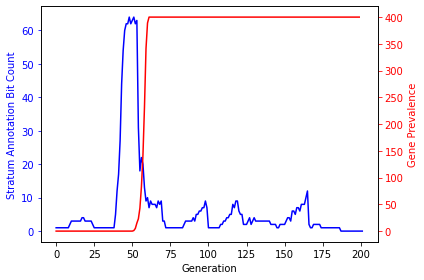

In [10]:
annotations = [
    s.GetAnnotation().bit_count()
    for s in population[0].gene_annotation.IterRetainedStrata()
]


def plot_sweep_and_annotations():
    # Create a figure and a single subplot
    fig, ax1 = plt.subplots()

    # Make the first plot on ax1
    sns.lineplot(data=annotations, color="b", ax=ax1)
    ax1.set_ylabel("Stratum Annotation Bit Count", color="b")
    ax1.tick_params("y", colors="b")

    # Create a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Make the second plot on ax2
    sns.lineplot(data=prevalences, color="r", ax=ax2)
    ax2.set_ylabel("Gene Prevalence", color="r")
    ax2.tick_params("y", colors="r")

    ax1.set_xlabel("Generation")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped


tp.tee(
    plot_sweep_and_annotations,
    teeplot_outattrs={
        "notebook": "gene-selection-inference",
        "replicate": str(MILL_REPLICATE),
        "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
    },
)


In [11]:
records = [
    {
        "notebook": "gene-selection-inference",
        "replicate": MILL_REPLICATE,
        "fitness-advantage": MILL_FITNESS_ADVANTAGE,
        "generation": generation,
        "prevalence": prevalence,
        "annotation": annotation,
    }
    for generation, (prevalence, annotation) in enumerate(
        zip(prevalences, annotations)
    )
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "prevalence-annotation-by-generation",
            "notebook": "gene-selection-inference",
            "replicate": str(MILL_REPLICATE),
            "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
            "ext": ".csv",
        }
    )
)
